Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/MachineLearningNotebooks/how-to-use-azureml/automated-machine-learning/forecasting-bike-share/auto-ml-forecasting-bike-share.png)

# Automated Machine Learning
**BikeShare Demand Forecasting**

## Contents
1. [Introduction](#Introduction)
1. [Setup](#Setup)
1. [Compute](#Compute)
1. [Data](#Data)
1. [Train](#Train)
1. [Featurization](#Featurization)
1. [Evaluate](#Evaluate)

## Introduction
This notebook demonstrates demand forecasting for a bike-sharing service using AutoML.

AutoML highlights here include built-in holiday featurization, accessing engineered feature names, and working with the `forecast` function. Please also look at the additional forecasting notebooks, which document lagging, rolling windows, forecast quantiles, other ways to use the forecast function, and forecaster deployment.

Make sure you have executed the [configuration notebook](../../../configuration.ipynb) before running this notebook.

Notebook synopsis:
1. Creating an Experiment in an existing Workspace
2. Configuration and local run of AutoML for a time-series model with lag and holiday features 
3. Viewing the engineered names for featurized data and featurization summary for all raw features
4. Evaluating the fitted model using a rolling test 

## Setup


In [2]:
import azureml.core
import pandas as pd
import numpy as np
import logging

from azureml.core import Workspace, Experiment, Dataset
from azureml.train.automl import AutoMLConfig
from datetime import datetime

As part of the setup you have already created a <b>Workspace</b>. To run AutoML, you also need to create an <b>Experiment</b>. An Experiment corresponds to a prediction problem you are trying to solve, while a Run corresponds to a specific approach to the problem.

In [3]:
from azureml.core.authentication import InteractiveLoginAuthentication
interactive_auth = InteractiveLoginAuthentication(tenant_id="ac5c5e7c-0141-491a-a5dd-d3608633ce62")
ws = Workspace.from_config()

# choose a name for the run history container in the workspace
experiment_name = 'automl-bikeshareforecasting'

experiment = Experiment(ws, experiment_name)

output = {}
output['SDK version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['SKU'] = ws.sku
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Run History Name'] = experiment_name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

WARNING - Warning: Falling back to use azure cli login credentials.
If you run your code in unattended mode, i.e., where you can't give a user input, then we recommend to use ServicePrincipalAuthentication or MsiAuthentication.
Please refer to aka.ms/aml-notebook-auth for different authentication mechanisms in azureml-sdk.


,
SDK version,1.1.5
Subscription ID,01644559-ad8e-40d4-9bf2-6c5e3213a8bf
Workspace,wsAzureNoteBooks
SKU,Enterprise
Resource Group,rgAzureNotebooks
Location,eastus
Run History Name,automl-bikeshareforecasting


## Compute
You will need to create a [compute target](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-set-up-training-targets#amlcompute) for your AutoML run. In this tutorial, you create AmlCompute as your training compute resource.
#### Creation of AmlCompute takes approximately 5 minutes. 
If the AmlCompute with that name is already in your workspace this code will skip the creation process.
As with other Azure services, there are limits on certain resources (e.g. AmlCompute) associated with the Azure Machine Learning service. Please read this article on the default limits and how to request more quota.

In [4]:
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget

# Choose a name for your cluster.
amlcompute_cluster_name = "cpu-cluster-bike"

found = False
# Check if this compute target already exists in the workspace.
cts = ws.compute_targets
if amlcompute_cluster_name in cts and cts[amlcompute_cluster_name].type == 'AmlCompute':
    found = True
    print('Found existing compute target.')
    compute_target = cts[amlcompute_cluster_name]
    
if not found:
    print('Creating a new compute target...')
    provisioning_config = AmlCompute.provisioning_configuration(vm_size = "STANDARD_D2_V2", # for GPU, use "STANDARD_NC6"
                                                                #vm_priority = 'lowpriority', # optional
                                                                max_nodes = 4)

    # Create the cluster.
    compute_target = ComputeTarget.create(ws, amlcompute_cluster_name, provisioning_config)
    
print('Checking cluster status...')
# Can poll for a minimum number of nodes and for a specific timeout.
# If no min_node_count is provided, it will use the scale settings for the cluster.
compute_target.wait_for_completion(show_output = True, min_node_count = None, timeout_in_minutes = 20)
    
# For a more detailed view of current AmlCompute status, use get_status().

Found existing compute target.
Checking cluster status...
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


## Data

The [Machine Learning service workspace](https://docs.microsoft.com/en-us/azure/machine-learning/service/concept-workspace) is paired with the storage account, which contains the default data store. We will use it to upload the bike share data and create [tabular dataset](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.data.tabulardataset?view=azure-ml-py) for training. A tabular dataset defines a series of lazily-evaluated, immutable operations to load data from the data source into tabular representation.

In [5]:
datastore = ws.get_default_datastore()
datastore.upload_files(files = ['./bike-no.csv'], target_path = 'dataset/', overwrite = True,show_progress = True)

Uploading an estimated of 1 files
Uploading ./bike-no.csv
Uploaded ./bike-no.csv, 1 files out of an estimated total of 1
Uploaded 1 files


$AZUREML_DATAREFERENCE_d4fac7622c2f4fb199ff925c03cc0090

Let's set up what we know about the dataset. 

**Target column** is what we want to forecast.

**Time column** is the time axis along which to predict.

In [6]:
target_column_name = 'cnt'
time_column_name = 'date'

In [7]:
dataset = Dataset.Tabular.from_delimited_files(path = [(datastore, 'dataset/bike-no.csv')]).with_timestamp_columns(fine_grain_timestamp=time_column_name) 
dataset.take(5).to_pandas_dataframe().reset_index(drop=True)

,instant,date,season,yr,mnth,weekday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,6,2,0.34,0.36,0.81,0.16,331,654,985
1,2,2011-01-02,1,0,1,0,2,0.36,0.35,0.70,0.25,131,670,801
2,3,2011-01-03,1,0,1,1,1,0.20,0.19,0.44,0.25,120,1229,1349
3,4,2011-01-04,1,0,1,2,1,0.20,0.21,0.59,0.16,108,1454,1562
4,5,2011-01-05,1,0,1,3,1,0.23,0.23,0.44,0.19,82,1518,1600


### Split the data

The first split we make is into train and test sets. Note we are splitting on time. Data before 9/1 will be used for training, and data after and including 9/1 will be used for testing.

In [8]:
# select data that occurs before a specified date
train = dataset.time_before(datetime(2012, 8, 31), include_boundary=True)
train.to_pandas_dataframe().tail(5).reset_index(drop=True)

,instant,date,season,yr,mnth,weekday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,605,2012-08-27,3,1,8,1,1,0.70,0.65,0.73,0.13,989,5928,6917
1,606,2012-08-28,3,1,8,2,1,0.73,0.67,0.62,0.19,935,6105,7040
2,607,2012-08-29,3,1,8,3,1,0.69,0.64,0.55,0.11,1177,6520,7697
3,608,2012-08-30,3,1,8,4,1,0.71,0.65,0.59,0.08,1172,6541,7713
4,609,2012-08-31,3,1,8,5,1,0.76,0.69,0.59,0.17,1433,5917,7350


In [9]:
test = dataset.time_after(datetime(2012, 9, 1), include_boundary=True)
test.to_pandas_dataframe().head(5).reset_index(drop=True)

,instant,date,season,yr,mnth,weekday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,610,2012-09-01,3,1,9,6,2,0.75,0.70,0.64,0.11,2352,3788,6140
1,611,2012-09-02,3,1,9,0,2,0.70,0.65,0.81,0.06,2613,3197,5810
2,612,2012-09-03,3,1,9,1,1,0.71,0.66,0.79,0.15,1965,4069,6034
3,613,2012-09-04,3,1,9,2,1,0.73,0.69,0.76,0.24,867,5997,6864
4,614,2012-09-05,3,1,9,3,1,0.74,0.71,0.74,0.19,832,6280,7112


## Train

Instantiate a AutoMLConfig object. This defines the settings and data used to run the experiment.

|Property|Description|
|-|-|
|**task**|forecasting|
|**primary_metric**|This is the metric that you want to optimize.<br> Forecasting supports the following primary metrics <br><i>spearman_correlation</i><br><i>normalized_root_mean_squared_error</i><br><i>r2_score</i><br><i>normalized_mean_absolute_error</i>
|**blacklist_models**|Models in blacklist won't be used by AutoML. All supported models can be found at [here](https://docs.microsoft.com/en-us/python/api/azureml-train-automl-client/azureml.train.automl.constants.supportedmodels.forecasting?view=azure-ml-py).|
|**experiment_timeout_hours**|Experimentation timeout in hours.|
|**training_data**|Input dataset, containing both features and label column.|
|**label_column_name**|The name of the label column.|
|**compute_target**|The remote compute for training.|
|**n_cross_validations**|Number of cross validation splits.|
|**enable_early_stopping**|If early stopping is on, training will stop when the primary metric is no longer improving.|
|**time_column_name**|Name of the datetime column in the input data|
|**max_horizon**|Maximum desired forecast horizon in units of time-series frequency|
|**country_or_region**|The country/region used to generate holiday features. These should be ISO 3166 two-letter country/region codes (i.e. 'US', 'GB').|
|**target_lags**|The target_lags specifies how far back we will construct the lags of the target variable.|
|**drop_column_names**|Name(s) of columns to drop prior to modeling|

This notebook uses the blacklist_models parameter to exclude some models that take a longer time to train on this dataset. You can choose to remove models from the blacklist_models list but you may need to increase the experiment_timeout_hours parameter value to get results.

### Setting forecaster maximum horizon 

The forecast horizon is the number of periods into the future that the model should predict. Here, we set the horizon to 14 periods (i.e. 14 days). Notice that this is much shorter than the number of days in the test set; we will need to use a rolling test to evaluate the performance on the whole test set. For more discussion of forecast horizons and guiding principles for setting them, please see the [energy demand notebook](https://github.com/Azure/MachineLearningNotebooks/tree/master/how-to-use-azureml/automated-machine-learning/forecasting-energy-demand).  

In [10]:
max_horizon = 14

### Config AutoML

In [11]:
time_series_settings = {
    'time_column_name': time_column_name,
    'max_horizon': max_horizon,    
    'country_or_region': 'US', # set country_or_region will trigger holiday featurizer
    'target_lags': 'auto', # use heuristic based lag setting    
    'drop_column_names': ['casual', 'registered','instant'] # these columns are a breakdown of the total and therefore a leak
}

automl_config = AutoMLConfig(task='forecasting',                             
                             primary_metric='normalized_root_mean_squared_error',
                             blacklist_models = ['ExtremeRandomTrees'],                             
                             experiment_timeout_hours=0.3,
                             training_data=train,
                             label_column_name=target_column_name,
                             compute_target=compute_target,
                             enable_early_stopping=True,
                             n_cross_validations=3, 
                             max_concurrent_iterations=4,
                             max_cores_per_iteration=-1,
                             verbosity=logging.INFO,
                            **time_series_settings)

We will now run the experiment, you can go to Azure ML portal to view the run details. 

In [12]:
remote_run = experiment.submit(automl_config, show_output=False)
remote_run

Experiment,Id,Type,Status,Details Page,Docs Page
automl-bikeshareforecasting,AutoML_d2351809-74d0-47e9-bf6a-4a0f560a3b48,automl,Starting,Link to Azure Machine Learning studio,Link to Documentation


In [13]:
remote_run.wait_for_completion()

WARNING - Retrying (Retry(total=2, connect=2, read=3, redirect=None, status=None)) after connection broken by 'NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000001538ADC4390>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it',)': /history/v1.0/subscriptions/01644559-ad8e-40d4-9bf2-6c5e3213a8bf/resourceGroups/rgAzureNotebooks/providers/Microsoft.MachineLearningServices/workspaces/wsAzureNoteBooks/experiments/automl-bikeshareforecasting/runs/AutoML_d2351809-74d0-47e9-bf6a-4a0f560a3b48
WARNING - Retrying (Retry(total=2, connect=2, read=3, redirect=None, status=None)) after connection broken by 'NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000001538AE5DAC8>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it',)': /history/v1.0/subscriptions/01644559-ad8e-40d4-9bf2-6c5e3213

{'runId': 'AutoML_d2351809-74d0-47e9-bf6a-4a0f560a3b48',
 'target': 'cpu-cluster-bike',
 'status': 'Completed',
 'startTimeUtc': '2020-03-19T23:37:16.032113Z',
 'endTimeUtc': '2020-03-19T23:58:53.605981Z',
 'properties': {'num_iterations': '1000',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'normalized_root_mean_squared_error',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': '3',
  'target': 'cpu-cluster-bike',
  'RawAMLSettingsString': "{'name': 'automl-bikeshareforecasting', 'path': None, 'subscription_id': '01644559-ad8e-40d4-9bf2-6c5e3213a8bf', 'resource_group': 'rgAzureNotebooks', 'workspace_name': 'wsAzureNoteBooks', 'region': 'eastus', 'compute_target': 'cpu-cluster-bike', 'spark_service': None, 'azure_service': 'remote', 'iterations': 1000, 'primary_metric': 'normalized_root_mean_squared_error', 'task_type': 'regression', 'data_script': None, 'validation_size': 0.0, 'n_cross_validations': 3, 'y_min': None, 

### Retrieve the Best Model
Below we select the best model from all the training iterations using get_output method.

In [14]:
best_run, fitted_model = remote_run.get_output()
fitted_model.steps

[('timeseriestransformer',
  TimeSeriesTransformer(logger=None,
             pipeline_type=<TimeSeriesPipelineType.FULL: 1>)),
 ('stackensembleregressor',
  StackEnsembleRegressor(base_learners=[('11', Pipeline(memory=None,
       steps=[('maxabsscaler', MaxAbsScaler(copy=True)), ('decisiontreeregressor', DecisionTreeRegressor(criterion='friedman_mse', max_depth=None,
             max_features=0.5, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None...    min_weight_fraction_leaf=0.0, presort=False, random_state=None,
             splitter='best'))]))],
              meta_learner=ElasticNetCV(alphas=None, copy_X=True, cv='warn', eps=0.001,
         fit_intercept=True, l1_ratio=0.5, max_iter=1000, n_alphas=100,
         n_jobs=None, normalize=False, positive=False, precompute='auto',
         random_state=None, selection='cyclic', tol=0.0001, verbose=0),
              training_cv_folds=5))]

## Featurization

You can access the engineered feature names generated in time-series featurization. Note that a number of named holiday periods are represented. We recommend that you have at least one year of data when using this feature to ensure that all yearly holidays are captured in the training featurization.

In [15]:
fitted_model.named_steps['timeseriestransformer'].get_engineered_feature_names()

['atemp',
 'atemp_WASNULL',
 'horizon_origin',
 'hum',
 'hum_WASNULL',
 'mnth',
 'mnth_WASNULL',
 'season',
 'season_WASNULL',
 'temp',
 'temp_WASNULL',
 'weathersit',
 'weathersit_WASNULL',
 'weekday',
 'weekday_WASNULL',
 'windspeed',
 'windspeed_WASNULL',
 'yr',
 'yr_WASNULL',
 '_automl_target_col_lag1D',
 'year',
 'year_iso',
 'half',
 'quarter',
 'month',
 'day',
 'wday',
 'qday',
 'week',
 '_IsPaidTimeOff',
 '_Holiday_1 day after Christmas Day',
 '_Holiday_1 day after Columbus Day',
 '_Holiday_1 day after Independence Day',
 '_Holiday_1 day after Labor Day',
 '_Holiday_1 day after Martin Luther King, Jr. Day',
 '_Holiday_1 day after Memorial Day',
 "_Holiday_1 day after New Year's Day",
 '_Holiday_1 day after Thanksgiving',
 '_Holiday_1 day after Veterans Day',
 "_Holiday_1 day after Washington's Birthday",
 '_Holiday_1 day before Christmas Day',
 '_Holiday_1 day before Columbus Day',
 '_Holiday_1 day before Independence Day',
 '_Holiday_1 day before Labor Day',
 '_Holiday_1 day 

### View the featurization summary

You can also see what featurization steps were performed on different raw features in the user data. For each raw feature in the user data, the following information is displayed:

- Raw feature name
- Number of engineered features formed out of this raw feature
- Type detected
- If feature was dropped
- List of feature transformations for the raw feature

In [16]:
# Get the featurization summary as a list of JSON
featurization_summary = fitted_model.named_steps['timeseriestransformer'].get_featurization_summary()
# View the featurization summary as a pandas dataframe
pd.DataFrame.from_records(featurization_summary)

,Dropped,EngineeredFeatureCount,RawFeatureName,Transformations,TypeDetected
0,No,2,atemp,"[MeanImputer, ImputationMarker]",Numeric
1,No,105,date,"[MaxHorizonFeaturizer, DateTimeTransformer, DateTimeTransformer, DateTimeTransformer, DateTimeTransformer, DateTimeTransformer, DateTimeTransformer, DateTimeTransformer, DateTimeTransformer, DateTimeTransformer, DateTimeTransformer, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, DateTimeTransformer-OneHotEncoder, ...]",DateTime
2,No,2,hum,"[MeanImputer, ImputationMarker]",Numeric
3,No,2,mnth,"[MeanImputer, ImputationMarker]",Numeric
4,No,2,season,"[MeanImputer, ImputationMarker]",Numeric
5,No,2,temp,"[MeanImputer, ImputationMarker]",Numeric
6,No,2,weathersit,"[MeanImputer, ImputationMarker]",Numeric
7,No,2,weekday,"[MeanImputer, ImputationMarker]",Numeric
8,No,2,windspeed,"[MeanImputer, ImputationMarker]",Numeric
9,No,2,yr,"[MeanImputer, ImputationMarker]",Numeric


## Evaluate

We now use the best fitted model from the AutoML Run to make forecasts for the test set. We will do batch scoring on the test dataset which should have the same schema as training dataset.

The scoring will run on a remote compute. In this example, it will reuse the training compute.|

In [17]:
test_experiment = Experiment(ws, experiment_name + "_test")

### Retrieving forecasts from the model
To run the forecast on the remote compute we will use two helper scripts: forecasting_script and forecasting_helper. These scripts contain the utility methods which will be used by the remote estimator. We copy these scripts to the project folder to upload them to remote compute.

In [18]:
import os
import shutil

script_folder = os.path.join(os.getcwd(), 'forecast')
os.makedirs(script_folder, exist_ok=True)
shutil.copy2('forecasting_script.py', script_folder)
shutil.copy2('forecasting_helper.py', script_folder)

'E:\\Personal\\som\\work\\MLAI\\code\\MachineLearningNotebooks\\how-to-use-azureml\\automated-machine-learning\\forecasting-bike-share\\forecast\\forecasting_helper.py'

For brevity we have created the function called run_forecast. It submits the test data to the best model and run the estimation on the selected compute target.

In [19]:
from run_forecast import run_rolling_forecast

remote_run = run_rolling_forecast(test_experiment, compute_target, best_run, test, max_horizon,
                 target_column_name, time_column_name)
remote_run

Experiment,Id,Type,Status,Details Page,Docs Page
automl-bikeshareforecasting_test,automl-bikeshareforecasting_test_1584662584_f2bcf3da,azureml.scriptrun,Starting,Link to Azure Machine Learning studio,Link to Documentation


In [20]:
remote_run.wait_for_completion(show_output=False)

{'runId': 'automl-bikeshareforecasting_test_1584662584_f2bcf3da',
 'target': 'cpu-cluster-bike',
 'status': 'Finalizing',
 'startTimeUtc': '2020-03-20T00:04:31.06655Z',
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': 'f88144fe-a4f0-46a2-b1ff-808b7ce035b4',
  'azureml.git.repository_uri': 'https://github.com/Azure/MachineLearningNotebooks.git',
  'mlflow.source.git.repoURL': 'https://github.com/Azure/MachineLearningNotebooks.git',
  'azureml.git.branch': 'master',
  'mlflow.source.git.branch': 'master',
  'azureml.git.commit': '3d6caa10a378d77bf8c3b954b733424081b82e04',
  'mlflow.source.git.commit': '3d6caa10a378d77bf8c3b954b733424081b82e04',
  'azureml.git.dirty': 'True',
  'AzureML.DerivedImageName': 'azureml/azureml_d398a9eb1673e2df63631407e943e1fc',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [{'dataset': {'id': '0f358c9e-5638-4dd6-b812-6cad049e9312'}, 'consump

### Download the prediction result for metrics calcuation
The test data with predictions are saved in artifact outputs/predictions.csv. You can download it and calculation some error metrics for the forecasts and vizualize the predictions vs. the actuals.

In [22]:
remote_run.download_file('outputs/predictions.csv', 'predictions.csv')
df_all = pd.read_csv('predictions.csv')

[Test data scores]

r2_score:   0.702
normalized_root_mean_squared_error:   0.123
root_mean_squared_log_error:   nan
root_mean_squared_error:   1069.783
normalized_median_absolute_error:   0.094
explained_variance:   0.785
normalized_root_mean_squared_log_error:   nan
mean_absolute_error:   886.055
normalized_mean_absolute_error:   0.102
spearman_correlation:   0.892
mean_absolute_percentage_error:   156.192
median_absolute_error:   813.530


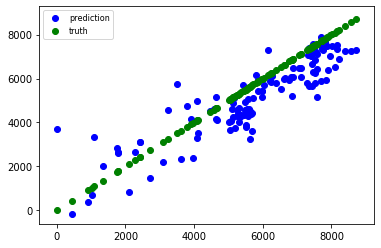

In [23]:
from azureml.automl.core._vendor.automl.client.core.common import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
from matplotlib import pyplot as plt
from automl.client.core.common import constants

# use automl metrics module
scores = metrics.compute_metrics_regression(
    df_all['predicted'],
    df_all[target_column_name],
    list(constants.Metric.SCALAR_REGRESSION_SET),
    None, None, None)

print("[Test data scores]\n")
for key, value in scores.items():    
    print('{}:   {:.3f}'.format(key, value))
    
# Plot outputs
%matplotlib inline
test_pred = plt.scatter(df_all[target_column_name], df_all['predicted'], color='b')
test_test = plt.scatter(df_all[target_column_name], df_all[target_column_name], color='g')
plt.legend((test_pred, test_test), ('prediction', 'truth'), loc='upper left', fontsize=8)
plt.show()

The MAPE seems high; it is being skewed by an actual with a small absolute value. For a more informative evaluation, we can calculate the metrics by forecast horizon:

In [24]:
from metrics_helper import MAPE, APE
df_all.groupby('horizon_origin').apply(
    lambda df: pd.Series({'MAPE': MAPE(df[target_column_name], df['predicted']),
                          'RMSE': np.sqrt(mean_squared_error(df[target_column_name], df['predicted'])),
                          'MAE': mean_absolute_error(df[target_column_name], df['predicted'])}))

,MAPE,RMSE,MAE
horizon_origin,,,
1,20.83,1142.67,1047.55
2,18.14,839.33,666.56
3,1862.55,1343.10,831.06
4,41.73,1235.63,1035.71
5,30.06,1019.59,984.47
6,18.55,985.86,871.61
7,15.43,1012.95,849.02
8,18.75,1025.56,922.24
9,24.07,1160.54,1024.48


It's also interesting to see the distributions of APE (absolute percentage error) by horizon. On a log scale, the outlying APE in the horizon-3 group is clear.

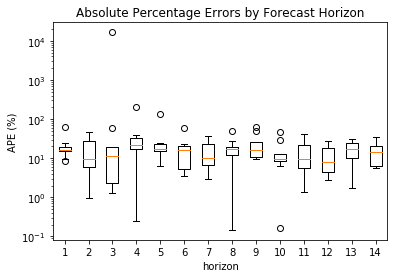

In [25]:
df_all_APE = df_all.assign(APE=APE(df_all[target_column_name], df_all['predicted']))
APEs = [df_all_APE[df_all['horizon_origin'] == h].APE.values for h in range(1, max_horizon + 1)]

%matplotlib inline
plt.boxplot(APEs)
plt.yscale('log')
plt.xlabel('horizon')
plt.ylabel('APE (%)')
plt.title('Absolute Percentage Errors by Forecast Horizon')

plt.show()